<a href="https://colab.research.google.com/github/db030220/Plogging/blob/main/trashmodel%EC%99%84%EC%84%B11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

In [8]:
import cv2

cap = cv2.VideoCapture(0)  # 웹캠에서 비디오 캡처 객체 생성
ret, frame = cap.read()   # 캡처된 프레임 읽기

if ret:  # 프레임이 정상적으로 읽어졌을 경우
    cv2.imshow('frame', frame)  # 이미지 출력
    cv2.imwrite('photo.jpg', frame)  # 이미지 저장
    cv2.waitKey(0)  # 키 입력 대기
    cap.release()  # 비디오 캡처 객체 해제
    cv2.destroyAllWindows()  # 모든 창 닫기
else:
    print("Cannot capture frame. Please check your camera.")
#노트북으로 확인할것

Cannot capture frame. Please check your camera.


In [ ]:
from PIL import Image
import os, glob, numpy as np
from sklearn.model_selection import train_test_split

In [ ]:
caltech_dir = "/content/drive/MyDrive/2023finalproject/img3/"
categories = ["person","hand","trash"]
nb_classes = len(categories)

image_w=64
image_h=64
pixels = image_h* image_w*3
X=[]
y=[]

for idx, cat in enumerate(categories):
  label=[0 for i in range(nb_classes)]
  label[idx] =1
  image_dir=caltech_dir +"/"+cat
  files=glob.glob(image_dir+"/*.jpg")
  print(cat, " 파일길이 : ", len(files))
  for i, f in enumerate(files):
    img=Image.open(f)
    img=img.convert("RGB")
    img=img.resize((image_w,image_h))
    data=np.asarray(img)

    X.append(data)
    y.append(label)

    if i%700==0:
      print(cat," : ",f)

X=np.array(X)
y=np.array(y)

X_train,X_test,y_train,y_test=train_test_split(X,y)
xy=(X_train, X_test,y_train,y_test)
np.save("/content/drive/MyDrive/2023finalproject/data.npy",xy)

print("ok",len(y))
#데이터증강완료

In [ ]:
import os, glob, numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from keras.backend import set_session as K

import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
#버전이상으로 변경
X_train, X_test, y_train, y_test = np.load('/content/drive/MyDrive/2023finalproject/data.npy',allow_pickle=True)
print(X_train.shape)
print(X_train.shape[0])
print(X_test.shape)
print(X_test.shape[0])

In [ ]:
categories = ["person","hand","trash"]
nb_classes = len(categories)

#일반화
X_train = X_train.astype(float) / 255
X_test = X_test.astype(float) / 255

In [ ]:
with tf.device('/device:GPU:0'):
    model = Sequential()
    model.add(Conv2D(32, (3,3), padding="same", input_shape=X_train.shape[1:], activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64, (3,3), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    #chatgpt에 기반한 추가 사항
    model.add(Conv2D(128, (3,3), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(nb_classes, activation='softmax'))
   # adam=tf.keras.optimizers.Adam(lr=0.001,beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model_dir = './model'
    
    if not os.path.exists(model_dir):
        os.mkdir(model_dir)
    
    model_path = model_dir + '/multi_img_classification.model'
    checkpoint = ModelCheckpoint(filepath=model_path , monitor='val_loss', verbose=1, save_best_only=True)
    early_stopping = EarlyStopping(monitor='val_loss', patience=6)
    
    

In [ ]:
model.summary()

In [ ]:
history = model.fit(X_train, y_train, batch_size=32, epochs=25, validation_data=(X_test, y_test), callbacks=[checkpoint, early_stopping])


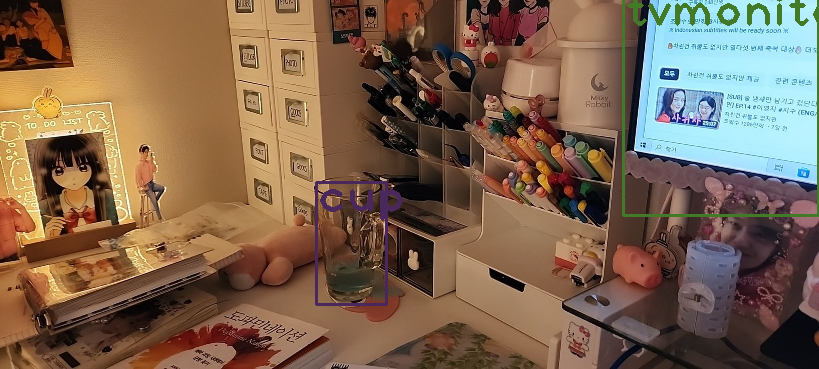

In [7]:

yolov3w='/content/drive/MyDrive/2023finalproject/yolov3.weights'
yolo3c='/content/drive/MyDrive/2023finalproject/yolov3.cfg'
# Load Yolo
net = cv2.dnn.readNet(yolov3w, yolo3c)
classes = []
coco='/content/drive/MyDrive/2023finalproject/coco.names'
with open(coco, "r") as f:
    classes = [line.strip() for line in f.readlines()]
layer_names = net.getLayerNames()
#[i[0]-1]
output_layers = [layer_names[i-1] for i in net.getUnconnectedOutLayers()]
colors = np.random.uniform(0, 255, size=(len(classes), 3))

# room='/content/drive/MyDrive/2023finalproject/room_ser.jpg'
# test='/content/_Zh8kvud.jpg_large'
# Loading image
imgname='photo.jpg'
img = cv2.imread(imgname)
img = cv2.resize(img, None, fx=0.4, fy=0.4)
height, width, channels = img.shape

# Detecting objects
blob = cv2.dnn.blobFromImage(img, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
net.setInput(blob)
outs = net.forward(output_layers)

# Showing informations on the screen
class_ids = []
confidences = []
boxes = []
for out in outs:
    for detection in out:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        #현재오류지점index 1256320 is out of bounds for axis 0 with size 27
        if confidence > 0.5:
            # Object detected
            center_x = int(detection[0] * width)
            center_y = int(detection[1] * height)
            w = int(detection[2] * width)
            h = int(detection[3] * height)
            # Rectangle coordinates
            x = int(center_x - w / 2)
            y = int(center_y - h / 2)
            boxes.append([x, y, w, h])
            confidences.append(float(confidence))
            class_ids.append(class_id)

indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

font = cv2.FONT_HERSHEY_PLAIN
for i in range(len(boxes)):
    if i in indexes:
        x, y, w, h = boxes[i]
        label = str(classes[class_ids[i]])
        color = colors[i]
        cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)
        cv2.putText(img, label, (x, y + 30), font, 3, color, 3)
cv2_imshow(img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
print("정확도 : %.4f" % (model.evaluate(X_test, y_test)[1]))

In [ ]:
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

x_len = np.arange(len(y_loss))

plt.plot(x_len, y_vloss, marker='.', c='red', label='val_set_loss')
plt.plot(x_len, y_loss, marker='.', c='blue', label='train_set_oss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.show()